In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import rcParams
import celerite
from celerite import terms
from celerite.modeling import Model
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial, jacrev
import ticktack
from ticktack import fitting
from astropy.table import Table

from chainconsumer import ChainConsumer

from scipy.optimize import minimize

rcParams['figure.figsize'] = (16.0, 8.0)

Here's an example using the Laplace approximation to infer a posterior without MCMC. It doesn't work yet!

First we load our model.

In [71]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')

In [3]:
cf = fitting.CarbonFitter(cbm)
cf.load_data('miyake12.csv')

Initialize some default parameters.

In [72]:
default_params = jnp.array([775., 1./12, np.pi/2., 81./12])

How long does log prob take to calculate? Pretty quick!

In [37]:
%%timeit
cf.log_prob(default_params).block_until_ready()

8.68 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Copy code from Angus Williams' [terrific tutorial](https://anguswilliams91.github.io/statistics/computing/jax/), noting that we have to use 2x `jacrev` instead of `hessian`.

In [50]:
@jit
def negative_log_posterior(theta):
    # negative log posterior to minimise
    return -1 * cf.log_prob(theta)

@jit
def grad_negative_log_posterior(theta):
    # gradient of the negative log posterior
    return grad(negative_log_posterior)(theta)

@jit
def approx_covariance_matrix(theta):
    # evaluate the covariance matrix of the approximate normal
    return jnp.linalg.inv(jacrev(jacrev(negative_log_posterior))(theta))


In [43]:
%%timeit
negative_log_posterior(default_params).block_until_ready()

8.13 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit # on my laptop, about 680 ms - kinda slow!
grad_negative_log_posterior(default_params).block_until_ready()

680 ms ± 53.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%time 
approx_covariance_matrix(default_params).block_until_ready()

CPU times: user 1min 47s, sys: 3.62 s, total: 1min 51s
Wall time: 1min 2s


DeviceArray([[ 3.39399934e-03, -6.26588797e-03,  2.39773453e-04,
              -2.75800453e-06],
             [-6.27434525e-03,  5.11202368e-02,  1.81592061e-02,
              -3.99056343e-04],
             [ 2.35791466e-04,  1.81673913e-02, -9.03912069e-02,
              -1.30383371e-03],
             [ 8.50353289e-07, -4.33924370e-04, -1.31684811e-03,
               5.33046513e-02]], dtype=float64)

Now do an optimization.

In [59]:
%%time

theta_star = minimize(
    negative_log_posterior, 
    default_params, 
    jac=grad_negative_log_posterior, 
    method="BFGS"
).x

sigma_approx = approx_covariance_matrix(theta_star)


CPU times: user 45.6 s, sys: 1.33 s, total: 46.9 s
Wall time: 46.9 s


In [64]:
samples = np.random.multivariate_normal(theta_star,sigma_approx,size=10000)

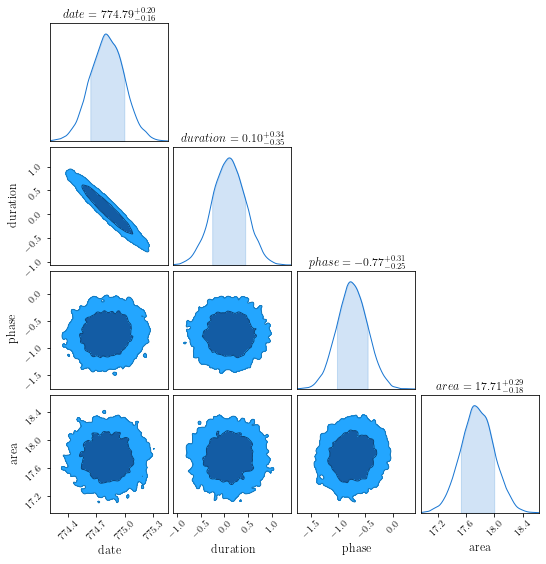

In [70]:
c = ChainConsumer()
c.add_chain(samples, parameters=["date", "duration", "phase", "area"])
fig = c.plotter.plot(figsize="column", truth=[0.0, 4.0])
fig.set_size_inches(3 + fig.get_size_inches())  # Resize fig for doco. You don't need this.
